<a href="https://colab.research.google.com/github/sachin-cw/Springboard-Capstone/blob/master/Quora_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment using Convolutional Neural Network on Quora Sincere-Insincere Questions Classification.

Load all the dependencies, create a dictionary for expanding Contractions and have all the functions created.


In [0]:
!pip install ipython-autotime
%load_ext autotime
# above lines get us the cell execution time.

%tensorflow_version 1.x 

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
#above lines help me avoid warnings thrown by sklearn


import re
import os

import unicodedata

import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

from datetime import datetime
from pytz import timezone
import time

from sklearn.model_selection import train_test_split


import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import sys, os, re, csv, codecs
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import gensim.models.keyedvectors as word2vec
import gc

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve,precision_recall_fscore_support
  
from google.colab import drive

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')




CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}






from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'


    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax





def remove_special_chars(text):
  return re.sub(r'[^a-zA-Z0-9 \']', '', text)

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def tokenize_text(text):
  tokens = nltk.word_tokenize(text)
  tokens = [token.strip() for token in tokens]
  return tokens

def normalize_text(text):
  text=remove_special_chars(text)
  text=expand_contractions(text)
  #text=text.lower()                       ## tried this for CNN based on Kaggle first place solution; makes sense because words such as How, Why,etc would typically begin in a sentence and will be camcelcased
  text=remove_accented_chars(text)
  #text=tokenize_text(text)
  return text

def remove_stopwords_nltk(tokens):
  filtered_tokens = [token for token in tokens if token not in stop_words]
  filtered_text = ' '.join(filtered_tokens)    
  return filtered_text




def stem_sentences_nltk(sentence):
  ps = PorterStemmer()
  tokens = sentence.split()
  stemmed_tokens = [ps.stem(token) for token in tokens]
  return ' '.join(stemmed_tokens)


  
  
def stem_sentences_list(sentence):
  ps = PorterStemmer()
  tokens = sentence.split()
  stemmed_tokens = [ps.stem(token) for token in tokens]
  return stemmed_tokens

 
def tfidf_vectorize_get_array(series):
  vectorizer = TfidfVectorizer(min_df=1,norm='l2',smooth_idf=True,use_idf=True,ngram_range=(1,1))
  return np.array(vectorizer.fit_transform(series).todense(), dtype=np.float16)

def tfidf_vectorize(series):
  vectorizer = TfidfVectorizer(min_df=1,norm='l2',smooth_idf=True,use_idf=True,ngram_range=(1,1))
  return vectorizer.fit_transform(series)

# gonna try without removal of stop words first, might try with removal of stop words later

def preprocess_text(df,stem=False):
  if stem:
    df['word_tokens_stemmed']=df['question_text'].apply(normalize_text).apply(tokenize_text).apply(remove_stopwords_nltk).apply(stem_sentences_nltk)
  else:
    #df['word_tokens_preprocessed']=df['question_text'].apply(normalize_text).apply(tokenize_text).apply(remove_stopwords_nltk)
    df['word_tokens_preprocessed']=df['question_text'].apply(normalize_text)
  return df




def split_train_test(df,stem=False):
  if stem:
    x_train,x_test,y_train,y_test = train_test_split(df['word_tokens_stemmed'],df['target'], random_state=1,stratify=df['target'])
  else:
    x_train,x_test,y_train,y_test = train_test_split(df['word_tokens_preprocessed'],df['target'], random_state=1,stratify=df['target'])
  return x_train,x_test,y_train,y_test

def classifier_reports(y_test, y_pred):
  print()
  class_names = ['class0', 'class1']
  print(classification_report(y_test, y_pred, target_names=class_names))
  # Plot non-normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names,title='Confusion matrix, without normalization')
  # Plot normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
  plt.show()
  
  


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
time: 3.35 s


Mount the Google drive to load the training file later.

In [0]:
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/kaggle/quora')
!ls -ltr  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
total 12052983
-rw------- 1 root root 5646236541 Oct 24  2015 glove.840B.300d.txt
-rw------- 1 root root 2259088777 Mar 14  2018 wiki-news-300d-1M.vec
-rw------- 1 root root 3644258522 Oct 31  2018 GoogleNews-vectors-negative300.bin
drwx------ 2 root root       4096 Aug 25 19:03 paragram_300_sl999
-rw------- 1 root root   35011536 Aug 25 19:25 test.csv
-rw------- 1 root root  124206772 Aug 25 19:25 train.csv
-rw------- 1 root root    8643553 Aug 25 19:26 samp

Load the training file and preprocess it.

In [0]:
df=pd.read_csv('train.csv')

pd.options.display.max_colwidth = 500
print('Number rows and columns:',df.shape)

df=preprocess_text(df,stem=False)  
df.head()

Number rows and columns: (1306122, 3)


,qid,question_text,target,word_tokens_preprocessed
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,How did Quebec nationalists see their province as a nation in the 1960s
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,Do you have an adopted dog how would you encourage people to adopt and not shop
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,Why does velocity affect time Does velocity affect space geometry
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0,How did Otto von Guericke used the Magdeburg hemispheres
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0,Can I convert montra helicon D to a mountain bike by just changing the tyres


time: 3min 4s


Below code is just a short demo on Tokenizer.

In [0]:

# define 5 documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!']
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

# summarize what was learned
print('word counts:',t.word_counts)
print('Doc count:',t.document_count)
print('Word Index',t.word_index)
print()
print(t.word_index.items())
print(t.word_docs)

word counts: OrderedDict([('well', 1), ('done', 1), ('good', 1), ('work', 2), ('great', 1), ('effort', 1), ('nice', 1), ('excellent', 1)])
Doc count: 5
Word Index {'work': 1, 'well': 2, 'done': 3, 'good': 4, 'great': 5, 'effort': 6, 'nice': 7, 'excellent': 8}

dict_items([('work', 1), ('well', 2), ('done', 3), ('good', 4), ('great', 5), ('effort', 6), ('nice', 7), ('excellent', 8)])
defaultdict(<class 'int'>, {'well': 1, 'done': 1, 'work': 2, 'good': 1, 'great': 1, 'effort': 1, 'nice': 1, 'excellent': 1})
time: 9.34 ms


Instantiate Tokenizer and fit it on preprocessed text.

In [0]:
tokenizer = Tokenizer(num_words = 38987)
tokenizer.fit_on_texts(df['word_tokens_preprocessed'])
print('Found %d unique words.' % len(tokenizer.word_index))

Found 247150 unique words.
time: 26.6 s


In [0]:
max_features = 247150 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df['word_tokens_preprocessed']))
encoded_docs = tokenizer.texts_to_sequences(df['word_tokens_preprocessed'])


time: 48.5 s


Make sure the encodings are there

In [0]:
encoded_docs[3]

[9, 46, 12957, 8315, 60372, 114, 1, 40009, 27169]

time: 3.42 ms


Make sure all the questions/samples are encoded.

In [0]:
len(encoded_docs)

1306122

time: 3.96 ms


Find the length of each question and plot a histogram of the lengths. This will help in padding later

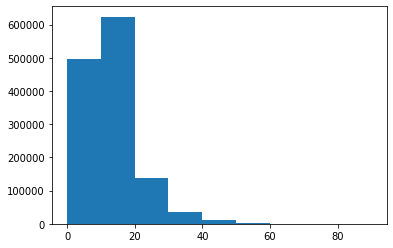

time: 568 ms


In [0]:
totalNumWords = [len(question) for question in encoded_docs]

plt.hist(totalNumWords,bins = np.arange(0,100,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

Pad the documents/samples/questions so that the length of samples is uniform.

In [0]:
maxlen = 50
X = pad_sequences(encoded_docs, maxlen=maxlen, padding='post')

time: 6.3 s


Define a function to create embedding matrix for our vocabulary ( unique words in the dataset) using pre trained word embeddings.

In [0]:
def loadEmbeddingMatrix(typeToLoad):
        
        if(typeToLoad=="glove"):
            EMBEDDING_FILE='glove.840B.300d.txt' #Common Crawl Data
            embed_size = 300
        elif(typeToLoad=="word2vec"):
            word2vecDict = word2vec.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
            embed_size = 300
        elif(typeToLoad=="fasttext"):
            EMBEDDING_FILE='wiki-news-300d-1M.vec'
            embed_size = 300

        if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
            embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
            f = open(EMBEDDING_FILE)
            for line in f:
                #split up line into an indexed array
                values = line.split()
                #first index is word
                word = values[0]
                #store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs 
            f.close()
            print('Loaded %s word vectors.' % len(embeddings_index))
        else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix,embeddedCount

time: 44.1 ms


Check how many words from our dataset could be found in the pre trained embeddings and find if the embedding matrix has embeddings for all words.

In [0]:
embedding_matrix,embeddedCount = loadEmbeddingMatrix('word2vec') # takes 1 min 23 secs on 25 gig ram and a GPU for Word2Vec, is able to find only 35% of words
print(embeddedCount / max_features *100)
print(embedding_matrix.shape)

Loaded 3000000 word vectors.
total embedded: 77874 common words
31.508800323690068
(247150, 300)
time: 1min 2s


y_2d = to_categorical(np.asarray(df['target'])) # needs to be used when you use conv2d

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_2d.shape)
print(y_2d)

Create the neural net architecture 

In [0]:
word_index=(tokenizer.word_index)
len(word_index)

# the dimension of vectors to be used
EMBEDDING_DIM = embedding_matrix.shape[1] #300
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512

# dropout probability
drop = 0.5
batch_size = 30
epochs = 2
vocab_size=len(word_index) # 247150 ; length of unique words

from keras.models import Sequential
from keras.layers import Embedding

model = Sequential()
model.add(layers.Embedding(vocab_size, EMBEDDING_DIM, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(layers.Conv1D(filters=512, kernel_size=3, activation='relu',))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           74145000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 512)           461312    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 74,639,209
Trainable params: 494,209
Non-trainable params: 74,145,000
_______________________________________________________________

In [0]:
y=df['target']

time: 1.48 ms


Define a function to plot training history - 

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

time: 9.76 ms


In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

x_train,x_test,y_train,y_test = train_test_split(X,y, random_state=42,stratify=y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)


batch_size = 32
epochs = 7
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,class_weight=class_weights, callbacks=[checkpoints, es])




Train on 783672 samples, validate on 195919 samples
Epoch 1/7
783672/783672 [==============================] - 128s 164us/step - loss: 0.1385 - acc: 0.9490 - val_loss: 0.1301 - val_acc: 0.9508
Epoch 2/7
783672/783672 [==============================] - 124s 159us/step - loss: 0.1137 - acc: 0.9560 - val_loss: 0.1379 - val_acc: 0.9509
Epoch 3/7
783672/783672 [==============================] - 123s 157us/step - loss: 0.0956 - acc: 0.9619 - val_loss: 0.1294 - val_acc: 0.9526
Epoch 4/7
783672/783672 [==============================] - 124s 158us/step - loss: 0.0787 - acc: 0.9685 - val_loss: 0.1376 - val_acc: 0.9514
Epoch 5/7
783672/783672 [==============================] - 123s 157us/step - loss: 0.0646 - acc: 0.9741 - val_loss: 0.1521 - val_acc: 0.9488
Epoch 6/7
783672/783672 [==============================] - 122s 156us/step - loss: 0.0536 - acc: 0.9785 - val_loss: 0.1819 - val_acc: 0.9491
Epoch 7/7
783672/783672 [==============================] - 123s 156us/step - loss: 0.0456 - acc: 0.9

Training Accuracy: 0.9774
Testing Accuracy:  0.9488


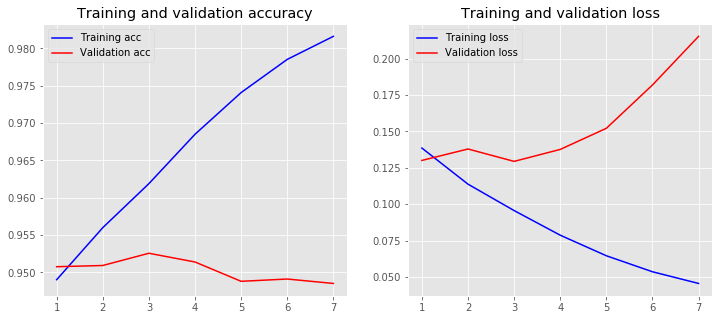

time: 52.9 s


In [0]:

loss, acc = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(acc))
loss, acc = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(acc))
plot_history(history)

Early Stopping is tried below-

In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

x_train,x_test,y_train,y_test = train_test_split(X,y, random_state=42,stratify=y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)


batch_size = 32
epochs = 7
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,class_weight=class_weights, callbacks=[checkpoints, es])


Train on 783672 samples, validate on 195919 samples
Epoch 1/7
783672/783672 [==============================] - 123s 157us/step - loss: 0.0394 - acc: 0.9841 - val_loss: 0.2152 - val_acc: 0.9468
Epoch 2/7
783672/783672 [==============================] - 124s 158us/step - loss: 0.0343 - acc: 0.9862 - val_loss: 0.2402 - val_acc: 0.9424
Epoch 00002: early stopping
time: 4min 8s


Training Accuracy: 0.9805
Testing Accuracy:  0.9424


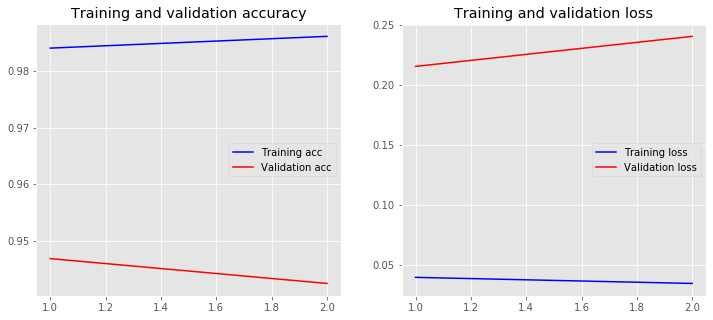

time: 52.5 s


In [0]:

loss, acc = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(acc))
loss, acc = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(acc))
plot_history(history)


              precision    recall  f1-score   support

      class0       0.96      0.98      0.97    306328
      class1       0.62      0.45      0.52     20203

    accuracy                           0.95    326531
   macro avg       0.79      0.72      0.75    326531
weighted avg       0.94      0.95      0.94    326531

Confusion matrix, without normalization
[[300662   5666]
 [ 11117   9086]]
Normalized confusion matrix
[[0.98150349 0.01849651]
 [0.55026481 0.44973519]]


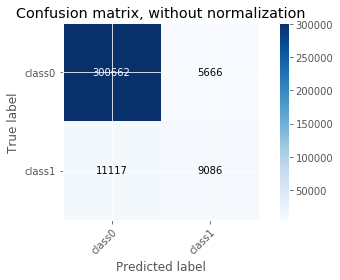

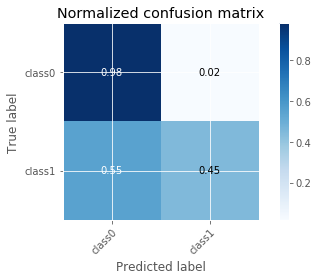

time: 23.4 s


In [0]:
y_pred=model.predict_classes(x_test)
y_pred
classifier_reports(y_test, y_pred)


              precision    recall  f1-score   support

      class0       0.97      0.97      0.97    306328
      class1       0.56      0.55      0.56     20203

    accuracy                           0.95    326531
   macro avg       0.77      0.76      0.76    326531
weighted avg       0.95      0.95      0.95    326531

Confusion matrix, without normalization
[[297621   8707]
 [  9046  11157]]
Normalized confusion matrix
[[0.97157622 0.02842378]
 [0.44775528 0.55224472]]


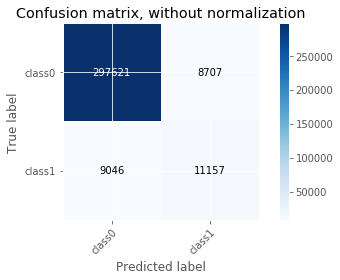

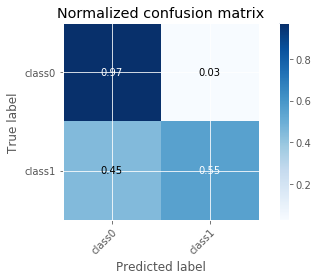

time: 22.7 s


In [0]:
y_pred=model.predict(x_test)
y_pred
classifier_reports(y_test, (y_pred>0.3).astype(int))